In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys

sys.path.append("..")

import os
from PIL import Image
from collections.abc import Iterable
from os.path import dirname, join, abspath

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from joblib import Parallel, delayed
from matplotlib.ticker import FuncFormatter
from skimage.color import label2rgb
from skimage.morphology import remove_small_objects, remove_small_holes
# load label
from skimage.measure import label, find_contours
from skimage import transform
import subprocess

from utils import *
from pred2raster import pred2raster
from sample_selection import get_components_stats
from src.io_operations import fix_relative_paths, load_args, read_tiff, read_yaml

from IPython.display import HTML, display

from millify import  millify

from matplotlib import rc

from statistics import mode

from tqdm import tqdm
from seaborn import color_palette
from glob import glob

from scipy.ndimage import distance_transform_edt, gaussian_filter
import gc

from concurrent.futures import ProcessPoolExecutor
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

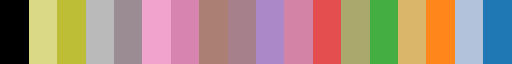

In [3]:
color_black = "#000000"
colors = color_palette("tab20", 18).as_hex()
colors.reverse()
colors = [color_black] + colors
cmap = LinearSegmentedColormap.from_list("mycmap", colors, N=18)
cmap

# First of All, Create an Empty Image Template

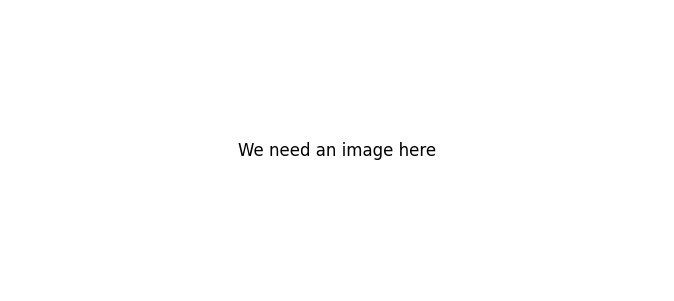

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=120)
# write on the middle that is missing a image here
ax.text(0.5, 0.5, "We need an image here", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.axis('off')
plt.show()

In [5]:
INPUT_FOLDER = "../amazon_input_data"
VERSAO = "13_amazon_data"
ITER_FOLDER = "iter_001"

In [6]:
args = load_args(join(ROOT_PATH, VERSAO, "args.yaml"))

In [7]:
ORTHOIMAGE = read_tiff(args.ortho_image)
ORTHOIMAGE = np.moveaxis(ORTHOIMAGE, 0, 2)

In [8]:
LABEL_GT_TRAIN = read_tiff(args.train_segmentation_path)

LABEL_GT_TEST = read_tiff(args.test_segmentation_path)

MASK = read_tiff(args.mask_path)

In [9]:
TRAIN_DISTANCE_MAP = read_tiff(join(ROOT_PATH, VERSAO, "iter_000", "distance_map","train_distance_map.tif"))

In [10]:
COMP_TEST_GT = label(LABEL_GT_TEST)
COMP_TRAIN_GT = label(LABEL_GT_TRAIN)

In [11]:
class_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "join_class*"))[0]
)+1

depth_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "depth*"))[0]
)
depth_pred = np.float32(depth_pred) / 255


prob_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "join_prob*"))[0]
)
prob_pred = np.float32(prob_pred) / 255

In [12]:
num_classes = pd.unique(pd.Series(class_pred.ravel())).shape[0]

In [13]:
DEFAULT_COLORS = color_palette("tab20", num_classes)
DEFAULT_COLORS.insert(0, (0,0,0))

In [17]:
# prob_gauss = gaussian_filter(prob_pred, sigma = 20)
# depth_gauss = gaussian_filter(depth_pred, sigma = 20)

with ProcessPoolExecutor() as executor:
    future_prob = executor.submit(gaussian_filter, prob_pred, 20)
    future_depth = executor.submit(gaussian_filter, depth_pred, 30)
    
    prob_gauss = future_prob.result()
    depth_gauss = future_depth.result()

# Mapa de Distribuição 

In [18]:
depth_gauss

array([[0.65357935, 0.65365434, 0.653804  , ..., 0.50955397, 0.509439  ,
        0.5093815 ],
       [0.65357625, 0.6536512 , 0.6538009 , ..., 0.509637  , 0.5095221 ,
        0.50946456],
       [0.65357   , 0.653645  , 0.65379477, ..., 0.50980306, 0.50968826,
        0.5096308 ],
       ...,
       [0.36191353, 0.3618209 , 0.3616359 , ..., 0.6351171 , 0.63494414,
        0.63485754],
       [0.36208826, 0.36199558, 0.36181042, ..., 0.6350853 , 0.6349124 ,
        0.63482577],
       [0.36217576, 0.36208302, 0.3618978 , ..., 0.6350694 , 0.63489646,
        0.6348099 ]], dtype=float32)

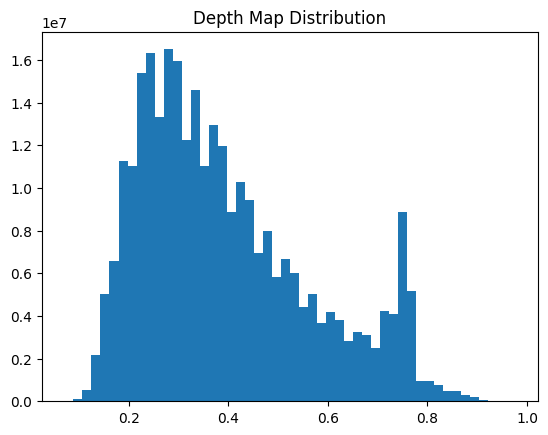

In [19]:
plt.title("Depth Map Distribution")
plt.hist(depth_pred.flatten(), bins=50)
plt.show()

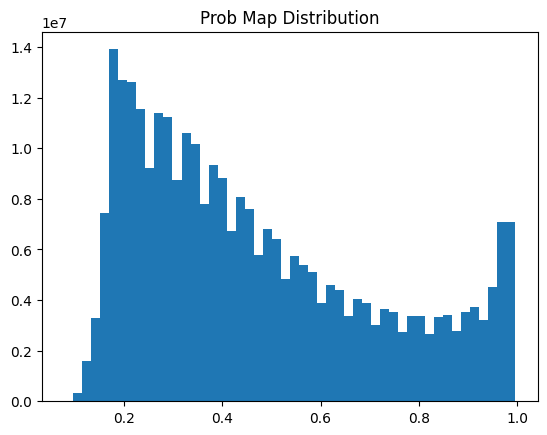

In [20]:
plt.title("Prob Map Distribution")
plt.hist(prob_pred.flatten(), bins=50)
plt.show()

# Mostrando etapas de tratamento entre a imagem, máscara binária e mapa de distâncias

/tmp/ipykernel_4139689/2884915881.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("magma")


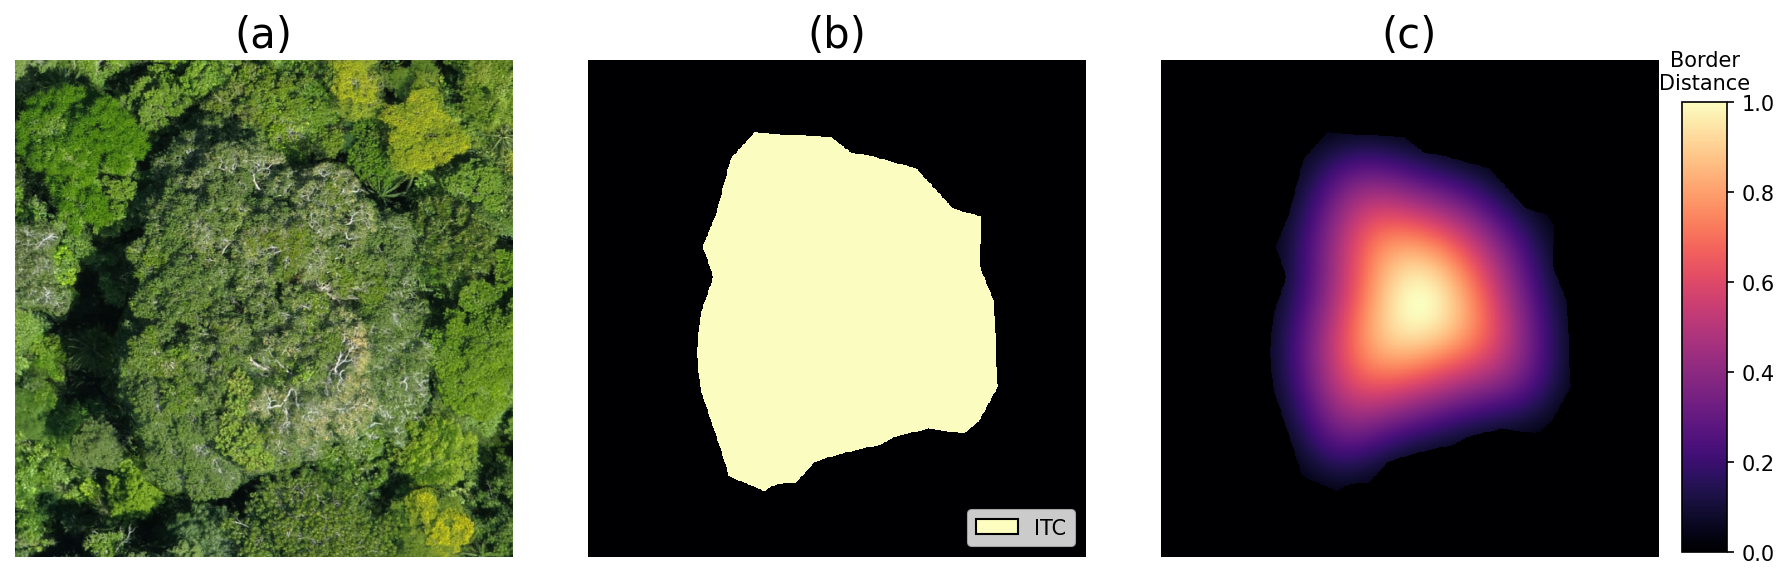

In [31]:


dim = 300
selected_tree = 300
DPI = 150

center = int(np.where(COMP_TRAIN_GT == selected_tree)[0].mean()), int(np.where(COMP_TRAIN_GT == selected_tree)[1].mean())

window_selected = slice(center[0] - dim, center[0] + dim), slice(center[1] - dim, center[1] + dim)

fig = plt.figure(dpi=DPI, figsize=(15, 5))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.2,)

fontsize = 20
legend_fontsize = 10  # Setting a small font size for legends

ax0 = fig.add_subplot(gs[0])
ax0.set_title("(a)", fontsize=fontsize)
ax0.imshow(ORTHOIMAGE[window_selected])

# Adding legend to plot (b)
ax1 = fig.add_subplot(gs[1])
ax1.set_title("(b)", fontsize=fontsize)
im_b = ax1.imshow(
    (COMP_TRAIN_GT[window_selected] == selected_tree).astype(int),
    cmap="magma",
    interpolation="nearest"
)
# Sample the color from the "magma" colormap for the value of `1`
cmap = cm.get_cmap("magma")
color_for_itc = cmap(1.0)  # Corresponds to the value `True` (1)

# Adding "ITC1" legend with the correct color from the colormap
legend_elements = [Patch(facecolor=color_for_itc, edgecolor='black', label='ITC')]
ax1.legend(
    handles=legend_elements,
    loc='lower right',
    prop={'size': legend_fontsize}
)

# Adding color bar to plot (c) with a title
ax2 = fig.add_subplot(gs[2])
ax2.set_title("(c)", fontsize=fontsize)
im_c = ax2.imshow(
    np.where(COMP_TRAIN_GT[window_selected] == selected_tree, TRAIN_DISTANCE_MAP[window_selected], 0),
    cmap="magma",
    interpolation="nearest"
)


# Manually create an axis for the color bar with specific dimensions
cax = fig.add_axes([0.866, 0.17,
                    0.02, 0.6])  # [left, bottom, width, height]

# Create the color bar in this custom axis
cbar = fig.colorbar(im_c, cax=cax, orientation="vertical")
cbar.ax.set_title("Border\nDistance", fontsize=legend_fontsize, pad=6)

# Set axis off
for a in [ax0, ax1, ax2]:
    a.axis("off")
    
# save as pdf
plt.savefig("figures/example_distance_map_generation.pdf", bbox_inches="tight", dpi=DPI)
plt.show()


## Comparação das Imagens com Diferentes Thresholds

In [22]:
prob_mask = prob_gauss > 0.7
depth_mask = depth_gauss > 0.35

high_prob_pred = np.where(prob_mask, class_pred, 0)
high_prob_depth_pred = np.where(prob_mask & depth_mask, class_pred, 0)

In [23]:
window_selected = slice(8000, 10_500), slice(12_000, 15_000)

window_high_prob = high_prob_pred[window_selected].copy()

mask_small = remove_small_objects(window_high_prob.astype(bool), min_size=3000)

window_high_prob[~mask_small] = 0

window_high_prob_depth = high_prob_depth_pred[window_selected].copy()

mask_small = remove_small_objects(window_high_prob_depth.astype(bool), min_size=3000)

window_high_prob_depth[~mask_small] = 0


In [24]:
# show default title size in matplotlib
plt.rcParams.update({'axes.titlesize': 'large'})

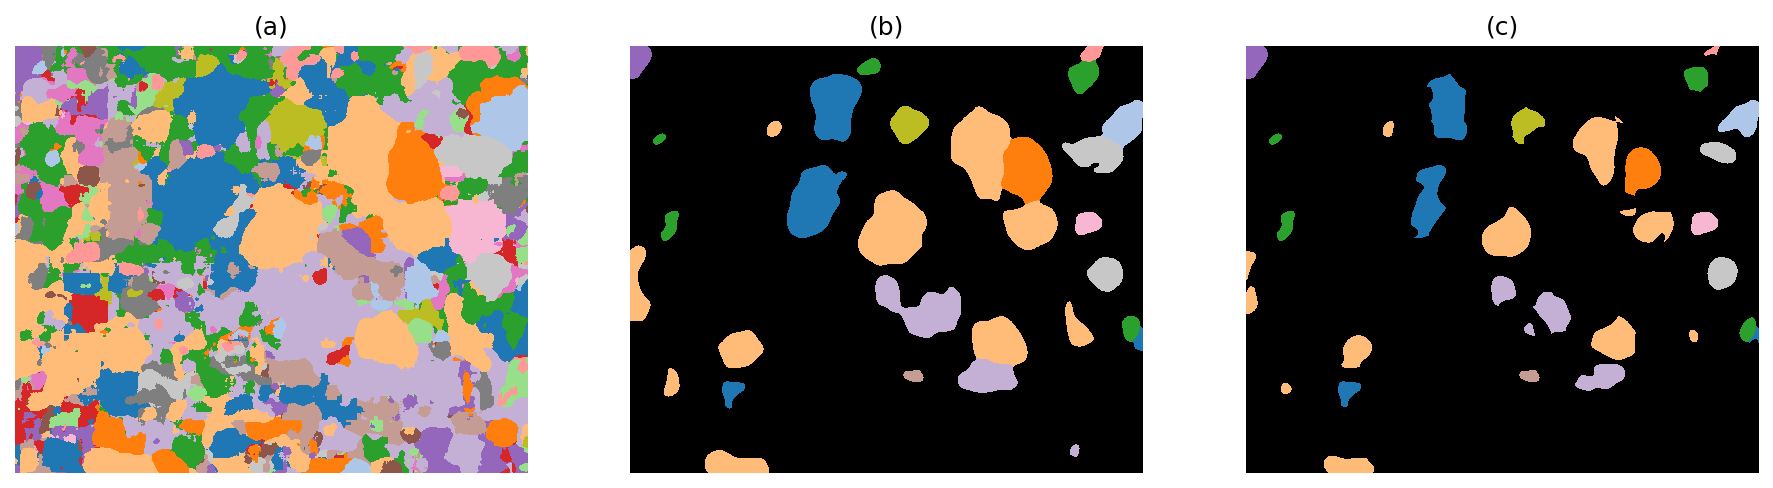

In [25]:
colors = np.array([(0,0,0)] + list(color_palette("tab20", 18)))
a
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

ax[0].set_title("(a)")
ax[0].imshow(colors[class_pred[window_selected]], interpolation="nearest")

ax[1].set_title("(b)")
ax[1].imshow(colors[window_high_prob], interpolation="nearest")

ax[2].set_title("(c)")
ax[2].imshow(colors[window_high_prob_depth], interpolation="nearest")

ax[2].set_title("(c)")
ax[2].imshow(colors[window_high_prob_depth], interpolation="nearest")


for a in ax:
    a.axis("off")

plt.show()

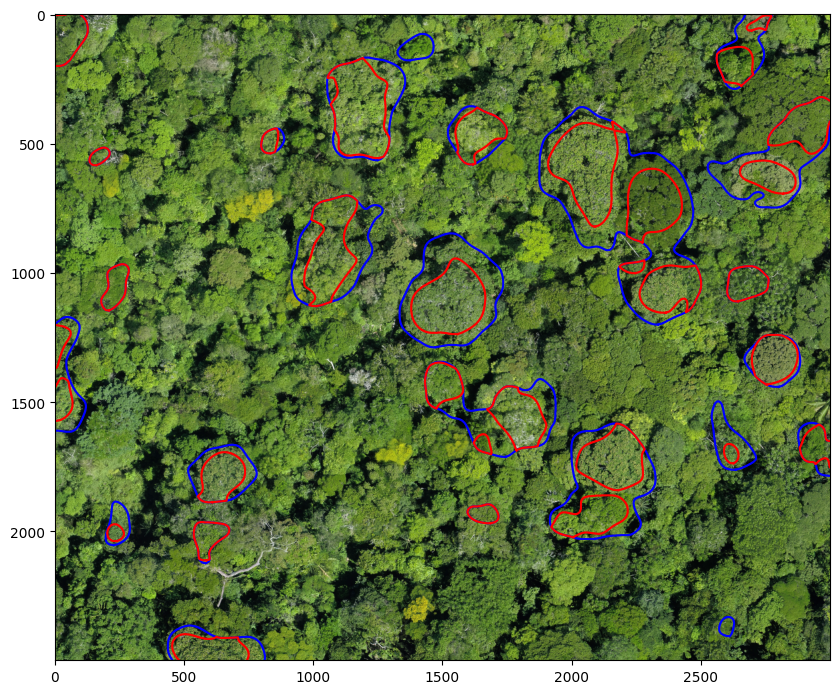

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(ORTHOIMAGE[window_selected])

for contour in find_contours(window_high_prob, 0.5):
    plt.plot(contour[:, 1], contour[:, 0], color="blue")

for contour in find_contours(window_high_prob_depth, 0.5):
    plt.plot(contour[:, 1], contour[:, 0], color="red")

# Visualização da Separação de Labels por Prob e Distance Map

## Ilustração dos Patches de Treinamento

In [14]:
quadrante_img = COMP_TRAIN_GT[7_000:14_500, 14_500:22_000].copy()

# set zero in all borders
width = 250
labels_in_borders = np.concatenate([
    np.unique(quadrante_img[:width,:]),
    np.unique(quadrante_img[-width:,:]),
    np.unique(quadrante_img[:,-width:]),
    np.unique(quadrante_img[:, :width])
])

quadrante_img = np.where(np.isin(quadrante_img,labels_in_borders), 0, quadrante_img)

quadrante_raw = ORTHOIMAGE[7_000:14_500, 14_500:22_000].copy()

In [15]:
all_coords = [ ]

for idx in np.unique(quadrante_img):
    if idx == 0:
        continue
    
    coords_quad = np.argwhere(quadrante_img == idx)
    
    random_idx = np.random.randint(0, coords_quad.shape[0], size = 3)

    coords_to_box = coords_quad[random_idx].copy()
    
    all_coords.append(coords_to_box.copy())


all_coords = np.concatenate(all_coords)

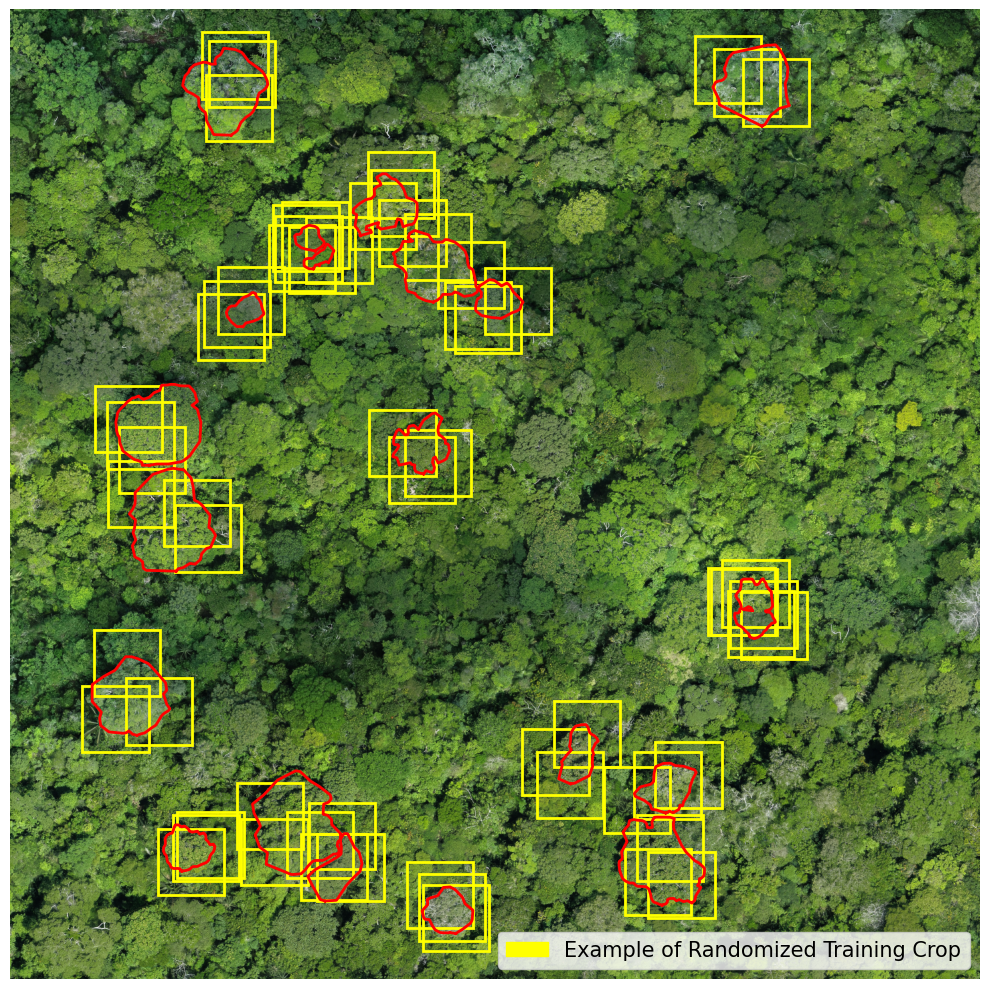

In [18]:
plt.figure(figsize = (10, 10))

plt.imshow(quadrante_raw)

width = 512
height = 512

for contour in find_contours(quadrante_img > 0):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color = "red")


for coord in all_coords:

    rand_x_add = int(np.random.uniform(-55, 55))
    rand_y_add = int(np.random.uniform(-55, 55))
    
    coord_x = coord[1] - width / 2 + rand_x_add
    coord_y = coord[0] - height / 2 + rand_y_add

    box = patches.Rectangle((coord_x, coord_y), width, height, linewidth=2, edgecolor='yellow', 
                            facecolor='none')
    # Get the current axes and add the box to the plot
    plt.gca().add_patch(box)


plt.grid(False)
plt.axis("off")

# Add a yellow line as a "patch" for demonstration
yellow_patch = patches.Patch(color='yellow', label='Example of Randomized Training Crop')


# Add the yellow line to the plot
plt.legend(handles=[yellow_patch], loc='lower right', fontsize = 15)  # Add legend with yellow line

plt.tight_layout()

# save as pdf
plt.savefig("figures/training_patches.pdf", dpi=300, bbox_inches="tight")

plt.show()